# EURUSD 15 Minutes Prediction Using Several Currency Pairs Feed Simultaneously

This notebook is base on this article 
[medium.com/daveyungookim](https://medium.com/@daveyungookim/forex-usdcad-predict-price-every-15-minutes-116554a424b5)


   # Define Constants

In [1]:
PAIRS_LIST        = ["EURUSD", "USDJPY", "EURJPY"] #, "USDCHF", "EURCHF"] #, "AUDUSD" ]
PREDICTING_PAIR   = "EURUSD" 
PREDICTING_COLUMN = "close"
LOOK_BACK         = 30 # 20 * 15 six hour
SPLIT             = 0.95 # data split ration for training and testing

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

./input\AUDUSD-2000-2020-15m.csv
./input\EURCHF-2000-2020-15m.csv
./input\EURJPY-2000-2020-15m.csv
./input\EURUSD-2000-2020-15m.csv
./input\USDCAD-2000-2020-15m.csv
./input\USDCHF-2000-2020-15m.csv
./input\USDJPY-2000-2020-15m.csv


# Installing and loading Dependencies

In [5]:
# import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, LSTM, Dense, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA, KernelPCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Used TA-Lib for creating additional features. More on this later.
from talib.abstract import *
from talib import MA_Type

import datetime

# Loading Data

In [6]:
# loading data
data = {}

for pair_name in PAIRS_LIST:
    data[pair_name] = pd.read_csv("./input/"+pair_name+"-2000-2020-15m.csv")

# normalize data shape and format
def norm_data_shape_format(df):
    orig_cols = ["DATE_TIME", "OPEN", "HIGH", "LOW", "CLOSE"]
    cols_name = ["timestamp", "open", "high", "low", "close"]
    df.rename(columns=dict(zip(orig_cols, cols_name)), inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
    df.set_index("timestamp", inplace=True)
    df = df.reindex(columns=cols_name[1:])
    return df.astype(float)
    
for key in data:
    data[key] = norm_data_shape_format(data[key])

In [7]:
data["EURUSD"].head()

,open,high,low,close
timestamp,,,,
2000-01-03 00:00:00,1.0073,1.0080,1.0073,1.0077
2000-01-03 00:15:00,1.0078,1.0087,1.0076,1.0086
2000-01-03 00:30:00,1.0087,1.0089,1.0079,1.0079
2000-01-03 00:45:00,1.0078,1.0132,1.0078,1.0128
2000-01-03 01:00:00,1.0129,1.0133,1.0120,1.0122


In [8]:
def extract_features(df):
    df['hour'] = df.index.hour
    df['day']  = df.index.weekday
    df['week'] = df.index.week
    # df['volume'] = pd.to_numeric(df['volume'])
    df['close']  = pd.to_numeric(df['close'])
    df['open']   = pd.to_numeric(df['open'])
    # df['momentum']   = df['volume'] * (df['open'] - df['close'])
    df['avg_price']  = (df['low'] + df['high'])/2
    df['range']      = df['high'] - df['low']
    df['ohlc_price'] = (df['low'] + df['high'] + df['open'] + df['close'])/4
    df['oc_diff']      = df['open'] - df['close']
    # df['spread_open']  = df['ask_open'] - df['bid_open']
    # df['spread_close'] = df['ask_close'] - df['bid_close']
    inputs = {
        'open'   : df['open'].values,
        'high'   : df['high'].values,
        'low'    : df['low'].values,
        'close'  : df['close'].values,
        'volume' : np.zeros(df['close'].shape[0]) # for sake of using TA lib
    }
    df['ema'] = MA(inputs, timeperiod=15, matype=MA_Type.T3)
    df['bear_power'] = df['low'] - df['ema']
    df['bull_power'] = df['high'] - df['ema']
    # Since computing EMA leave some of the rows empty, we want to remove them. (EMA is a lagging indicator)
    df.dropna(inplace=True)
    # Add 1D PCA vector as a feature as well. This helped increasing the accuracy by adding more variance to the feature set
    pca_input = df.drop('close', axis=1).copy()
    pca_features = pca_input.columns.tolist()
    pca = PCA(n_components=1)
    df['pca'] = pca.fit_transform(pca_input.values.astype('float32'))

columns_order = ["open", "high", "low", "close", "hour", "day", "week", 
                 "avg_price", "range", "ohlc_price", "oc_diff", "ema", "bear_power", "bull_power", "pca"]    

In [9]:
for key in data:
    extract_features(data[key])

In [10]:
data["EURUSD"].head()

,open,high,low,close,hour,day,week,avg_price,range,ohlc_price,oc_diff,ema,bear_power,bull_power,pca
timestamp,,,,,,,,,,,,,,,
2000-01-03 21:00:00,1.0273,1.0276,1.0261,1.0262,21,0,1,1.02685,0.0015,1.026800,0.0011,1.018835,0.007265,0.008765,-25.340296
2000-01-03 21:15:00,1.0261,1.0264,1.0256,1.0259,21,0,1,1.02600,0.0008,1.026000,0.0002,1.019785,0.005815,0.006615,-25.341299
2000-01-03 21:30:00,1.0256,1.0271,1.0256,1.0258,21,0,1,1.02635,0.0015,1.026025,-0.0002,1.020717,0.004883,0.006383,-25.341301
2000-01-03 21:45:00,1.0260,1.0260,1.0251,1.0256,21,0,1,1.02555,0.0009,1.025675,0.0004,1.021614,0.003486,0.004386,-25.341318
2000-01-03 22:00:00,1.0257,1.0267,1.0256,1.0264,22,0,1,1.02615,0.0011,1.026100,-0.0007,1.022467,0.003133,0.004233,-25.341690


In [12]:
#plt.plot(data['EURUSD'][2900:5150]["close"])
#plt.plot(data['EURUSD'][2900:5150]["ema"])
#plt.plot(data['EURUSD'][1900:2150]["bull_power"])
#plt.plot(data['EURUSD'][1900:2150]["bear_power"])
#plt.show()

# Merge All Pairs

In [13]:
# sort and rename column names
def sort_and_rename(df, suffix):
    cols_name = [c + suffix for c in columns_order]    
    df.rename(columns=dict(zip(columns_order,cols_name)), inplace=True)
    df = df.reindex(columns=cols_name, copy=False)
    return df
    
all_columns = [] # to save the correct order of data

for key in PAIRS_LIST:
    data[key] = sort_and_rename(data[key], "_" + key)
    all_columns += list(data[key].columns) # to save the correct order of data

In [14]:
# merge 
merged_data = pd.DataFrame(data[PAIRS_LIST[0]])
for key in PAIRS_LIST[1:]:
    merged_data = merged_data.merge(data[key], how="inner", left_index=True, right_index=True)
    
merged_data = merged_data.reindex(columns=all_columns)

# drop duplicate columns
for key in PAIRS_LIST[1:]:
    merged_data.drop(columns=[
        "hour_"+key,
        "day_" +key,
        "week_"+key,
    ],inplace=True)
    
merged_data.head()

,open_EURUSD,high_EURUSD,low_EURUSD,close_EURUSD,hour_EURUSD,day_EURUSD,week_EURUSD,avg_price_EURUSD,range_EURUSD,ohlc_price_EURUSD,...,low_EURJPY,close_EURJPY,avg_price_EURJPY,range_EURJPY,ohlc_price_EURJPY,oc_diff_EURJPY,ema_EURJPY,bear_power_EURJPY,bull_power_EURJPY,pca_EURJPY
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-01-03 21:00:00,1.0273,1.0276,1.0261,1.0262,21,0,1,1.02685,0.0015,1.026800,...,104.12,104.12,104.255,0.27,104.2300,0.17,103.538932,0.581068,0.851068,-59.624088
2000-01-03 21:15:00,1.0261,1.0264,1.0256,1.0259,21,0,1,1.02600,0.0008,1.026000,...,104.12,104.21,104.195,0.15,104.2075,0.02,103.629119,0.490881,0.640881,-59.689606
2000-01-03 21:30:00,1.0256,1.0271,1.0256,1.0258,21,0,1,1.02635,0.0015,1.026025,...,104.15,104.15,104.215,0.13,104.1950,0.05,103.716208,0.433792,0.563792,-59.646976
2000-01-03 21:45:00,1.0260,1.0260,1.0251,1.0256,21,0,1,1.02555,0.0009,1.025675,...,104.10,104.19,104.185,0.17,104.1850,-0.01,103.799257,0.300743,0.470743,-59.662064
2000-01-03 22:00:00,1.0257,1.0267,1.0256,1.0264,22,0,1,1.02615,0.0011,1.026100,...,104.18,104.32,104.250,0.14,104.2775,-0.03,103.878498,0.301502,0.441502,-59.467564


# A Little Exploration

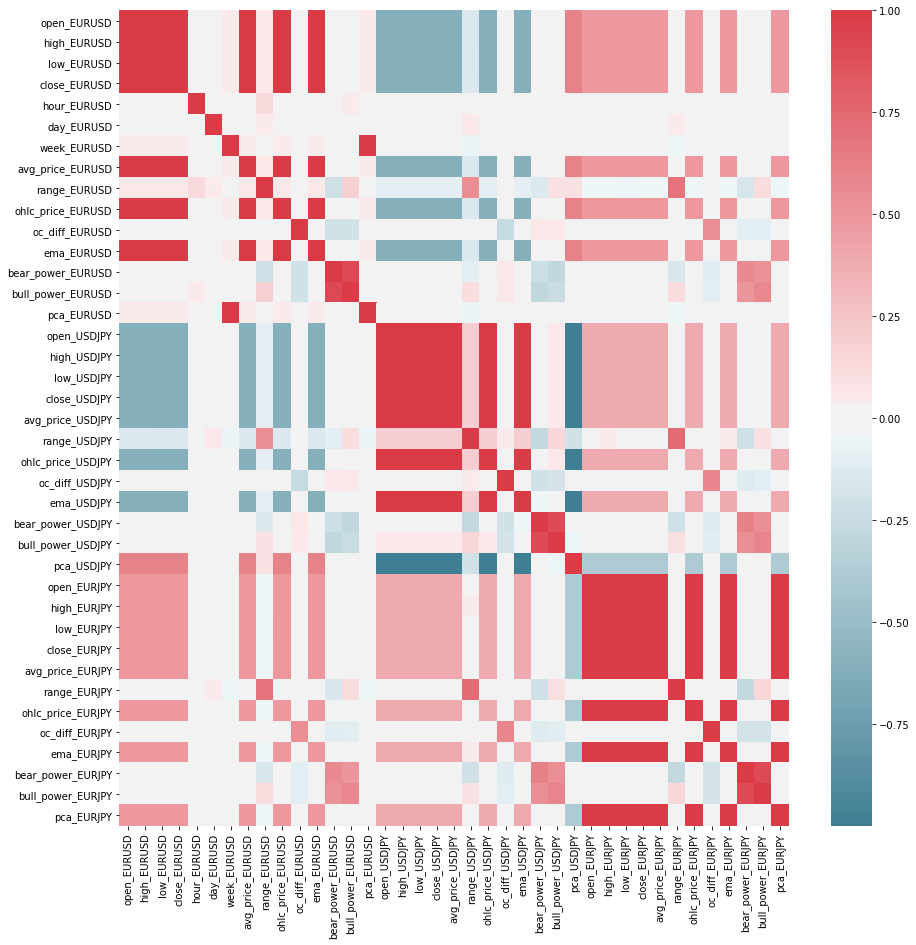

In [15]:
# seeing correlation between columns
corr = merged_data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, ax=ax)

In [16]:
merged_data.head()

,open_EURUSD,high_EURUSD,low_EURUSD,close_EURUSD,hour_EURUSD,day_EURUSD,week_EURUSD,avg_price_EURUSD,range_EURUSD,ohlc_price_EURUSD,...,low_EURJPY,close_EURJPY,avg_price_EURJPY,range_EURJPY,ohlc_price_EURJPY,oc_diff_EURJPY,ema_EURJPY,bear_power_EURJPY,bull_power_EURJPY,pca_EURJPY
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-01-03 21:00:00,1.0273,1.0276,1.0261,1.0262,21,0,1,1.02685,0.0015,1.026800,...,104.12,104.12,104.255,0.27,104.2300,0.17,103.538932,0.581068,0.851068,-59.624088
2000-01-03 21:15:00,1.0261,1.0264,1.0256,1.0259,21,0,1,1.02600,0.0008,1.026000,...,104.12,104.21,104.195,0.15,104.2075,0.02,103.629119,0.490881,0.640881,-59.689606
2000-01-03 21:30:00,1.0256,1.0271,1.0256,1.0258,21,0,1,1.02635,0.0015,1.026025,...,104.15,104.15,104.215,0.13,104.1950,0.05,103.716208,0.433792,0.563792,-59.646976
2000-01-03 21:45:00,1.0260,1.0260,1.0251,1.0256,21,0,1,1.02555,0.0009,1.025675,...,104.10,104.19,104.185,0.17,104.1850,-0.01,103.799257,0.300743,0.470743,-59.662064
2000-01-03 22:00:00,1.0257,1.0267,1.0256,1.0264,22,0,1,1.02615,0.0011,1.026100,...,104.18,104.32,104.250,0.14,104.2775,-0.03,103.878498,0.301502,0.441502,-59.467564


# Shaping Data

In [17]:
def create_dataset(df, look_back=10):
    dataX, dataY = [], []
    for i in range(len(df)-look_back-1):
        a = df[i:(i+look_back)]
        dataX.append(a)
        dataY.append(df[i + look_back])
    return np.array(dataX), np.array(dataY)

In [18]:
# Scale reshape and group the data

target_column_name = PREDICTING_COLUMN + "_" + PREDICTING_PAIR

# Create scalers
scaler = MinMaxScaler()
scaled = pd.DataFrame(scaler.fit_transform(merged_data), columns=merged_data.columns)

x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler = x_scaler.fit(merged_data.values.astype('float32'))
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = y_scaler.fit(merged_data[target_column_name].values.astype('float32').reshape(-1,1))

# Create dataset
target_index = scaled.columns.tolist().index(target_column_name)
dataset = scaled.values.astype('float32')

X, y = create_dataset(dataset, look_back=LOOK_BACK)
y = y[:,target_index]

train_size = int(len(X) * SPLIT)
trainX = X[:train_size]
trainY = y[:train_size]
testX = X[train_size:]
testY = y[train_size:]

In [19]:
print("all data shape:", X.shape)
print("train data shape:", trainX.shape)
print("test data shape:", testX.shape)

all data shape: (486899, 30, 39)
train data shape: (462554, 30, 39)
test data shape: (24345, 30, 39)


In [20]:
def create_model():
    model = Sequential()
    model.add(LSTM(20, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
    model.add(LSTM(20, return_sequences=True))
    model.add(LSTM(10, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(4, return_sequences=False))
    model.add(Dense(4, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
    print(model.summary())
    
    return model

In [21]:
model = create_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 20)            4800      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 20)            3280      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 10)            1240      
_________________________________________________________________
dropout (Dropout)            (None, 30, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 240       
_________________________________________________________________
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5

In [24]:
# Save the best weight during training.
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mse', verbose=1, save_best_only=True, mode='min')

# Monitor the trianing progress via TensorBoard
# log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard = TensorBoard(log_dir=log_dir)

# Callbacks
callbacks_list = [checkpoint] # , tensorboard]

# Fit
history = model.fit(trainX, trainY, epochs=200, batch_size=512, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/200
813/814 [============================>.] - ETA: 0s - loss: 0.0428 - mae: 0.1174 - mse: 0.0428
Epoch 00001: val_mse improved from inf to 0.00001, saving model to weights.best.hdf5
814/814 [==============================] - 59s 72ms/step - loss: 0.0427 - mae: 0.1174 - mse: 0.0427 - val_loss: 1.1099e-05 - val_mae: 0.0026 - val_mse: 1.1099e-05
Epoch 2/200
813/814 [============================>.] - ETA: 0s - loss: 1.5560e-04 - mae: 0.0095 - mse: 1.5560e-04
Epoch 00002: val_mse did not improve from 0.00001
814/814 [==============================] - 56s 69ms/step - loss: 1.5559e-04 - mae: 0.0095 - mse: 1.5559e-04 - val_loss: 1.1869e-05 - val_mae: 0.0028 - val_mse: 1.1869e-05
Epoch 3/200
813/814 [============================>.] - ETA: 0s - loss: 9.5519e-05 - mae: 0.0075 - mse: 9.5519e-05
Epoch 00003: val_mse improved from 0.00001 to 0.00001, saving model to weights.best.hdf5
814/814 [==============================] - 56s 69ms/step - loss: 9.5516e-05 - mae: 0.0075 - mse: 9.5516e-05 

Epoch 25/200
813/814 [============================>.] - ETA: 0s - loss: 1.3141e-05 - mae: 0.0028 - mse: 1.3141e-05
Epoch 00025: val_mse did not improve from 0.00000
814/814 [==============================] - 61s 75ms/step - loss: 1.3142e-05 - mae: 0.0028 - mse: 1.3142e-05 - val_loss: 8.2945e-06 - val_mae: 0.0026 - val_mse: 8.2945e-06
Epoch 26/200
813/814 [============================>.] - ETA: 0s - loss: 1.2870e-05 - mae: 0.0028 - mse: 1.2870e-05
Epoch 00026: val_mse did not improve from 0.00000
814/814 [==============================] - 61s 75ms/step - loss: 1.2870e-05 - mae: 0.0028 - mse: 1.2870e-05 - val_loss: 2.4050e-06 - val_mae: 0.0012 - val_mse: 2.4050e-06
Epoch 27/200
813/814 [============================>.] - ETA: 0s - loss: 1.2096e-05 - mae: 0.0027 - mse: 1.2096e-05
Epoch 00027: val_mse did not improve from 0.00000
814/814 [==============================] - 60s 74ms/step - loss: 1.2096e-05 - mae: 0.0027 - mse: 1.2096e-05 - val_loss: 4.9399e-06 - val_mae: 0.0019 - val_mse: 4.9

813/814 [============================>.] - ETA: 0s - loss: 7.6078e-06 - mae: 0.0021 - mse: 7.6078e-06
Epoch 00049: val_mse did not improve from 0.00000
814/814 [==============================] - 72s 88ms/step - loss: 7.6075e-06 - mae: 0.0021 - mse: 7.6075e-06 - val_loss: 1.2984e-05 - val_mae: 0.0032 - val_mse: 1.2984e-05
Epoch 50/200
813/814 [============================>.] - ETA: 0s - loss: 7.5245e-06 - mae: 0.0021 - mse: 7.5245e-06
Epoch 00050: val_mse did not improve from 0.00000
814/814 [==============================] - 67s 82ms/step - loss: 7.5243e-06 - mae: 0.0021 - mse: 7.5243e-06 - val_loss: 7.9980e-05 - val_mae: 0.0087 - val_mse: 7.9980e-05
Epoch 51/200
813/814 [============================>.] - ETA: 0s - loss: 7.0799e-06 - mae: 0.0020 - mse: 7.0799e-06
Epoch 00051: val_mse did not improve from 0.00000
814/814 [==============================] - 66s 81ms/step - loss: 7.0798e-06 - mae: 0.0020 - mse: 7.0798e-06 - val_loss: 4.0712e-05 - val_mae: 0.0060 - val_mse: 4.0712e-05
Epoch

Epoch 74/200
813/814 [============================>.] - ETA: 0s - loss: 5.4808e-06 - mae: 0.0018 - mse: 5.4808e-06
Epoch 00074: val_mse did not improve from 0.00000
814/814 [==============================] - 59s 73ms/step - loss: 5.4807e-06 - mae: 0.0018 - mse: 5.4807e-06 - val_loss: 9.3076e-05 - val_mae: 0.0093 - val_mse: 9.3076e-05
Epoch 75/200
813/814 [============================>.] - ETA: 0s - loss: 5.6125e-06 - mae: 0.0018 - mse: 5.6125e-06
Epoch 00075: val_mse did not improve from 0.00000
814/814 [==============================] - 59s 72ms/step - loss: 5.6126e-06 - mae: 0.0018 - mse: 5.6126e-06 - val_loss: 1.1870e-04 - val_mae: 0.0107 - val_mse: 1.1870e-04
Epoch 76/200
813/814 [============================>.] - ETA: 0s - loss: 5.4410e-06 - mae: 0.0018 - mse: 5.4410e-06
Epoch 00076: val_mse did not improve from 0.00000
814/814 [==============================] - 59s 72ms/step - loss: 5.4409e-06 - mae: 0.0018 - mse: 5.4409e-06 - val_loss: 1.8156e-04 - val_mae: 0.0133 - val_mse: 1.8

Epoch 99/200
813/814 [============================>.] - ETA: 0s - loss: 4.6585e-06 - mae: 0.0016 - mse: 4.6585e-06
Epoch 00099: val_mse did not improve from 0.00000
814/814 [==============================] - 58s 72ms/step - loss: 4.6584e-06 - mae: 0.0016 - mse: 4.6584e-06 - val_loss: 2.7321e-04 - val_mae: 0.0164 - val_mse: 2.7321e-04
Epoch 100/200
813/814 [============================>.] - ETA: 0s - loss: 4.4583e-06 - mae: 0.0016 - mse: 4.4583e-06
Epoch 00100: val_mse did not improve from 0.00000
814/814 [==============================] - 59s 72ms/step - loss: 4.4583e-06 - mae: 0.0016 - mse: 4.4583e-06 - val_loss: 2.0897e-04 - val_mae: 0.0143 - val_mse: 2.0897e-04
Epoch 101/200
814/814 [==============================] - ETA: 0s - loss: 4.4935e-06 - mae: 0.0016 - mse: 4.4935e-06
Epoch 00101: val_mse did not improve from 0.00000
814/814 [==============================] - 65s 80ms/step - loss: 4.4935e-06 - mae: 0.0016 - mse: 4.4935e-06 - val_loss: 2.8299e-04 - val_mae: 0.0167 - val_mse: 2

813/814 [============================>.] - ETA: 0s - loss: 3.9870e-06 - mae: 0.0015 - mse: 3.9870e-06
Epoch 00123: val_mse did not improve from 0.00000
814/814 [==============================] - 60s 74ms/step - loss: 3.9871e-06 - mae: 0.0015 - mse: 3.9871e-06 - val_loss: 2.4691e-04 - val_mae: 0.0156 - val_mse: 2.4691e-04
Epoch 124/200
813/814 [============================>.] - ETA: 0s - loss: 3.9694e-06 - mae: 0.0015 - mse: 3.9694e-06
Epoch 00124: val_mse did not improve from 0.00000
814/814 [==============================] - 59s 73ms/step - loss: 3.9694e-06 - mae: 0.0015 - mse: 3.9694e-06 - val_loss: 2.4033e-04 - val_mae: 0.0154 - val_mse: 2.4033e-04
Epoch 125/200
813/814 [============================>.] - ETA: 0s - loss: 3.8628e-06 - mae: 0.0015 - mse: 3.8628e-06
Epoch 00125: val_mse did not improve from 0.00000
814/814 [==============================] - 59s 73ms/step - loss: 3.8627e-06 - mae: 0.0015 - mse: 3.8627e-06 - val_loss: 2.7890e-04 - val_mae: 0.0165 - val_mse: 2.7890e-04
Epo

Epoch 148/200
813/814 [============================>.] - ETA: 0s - loss: 3.5312e-06 - mae: 0.0014 - mse: 3.5312e-06
Epoch 00148: val_mse did not improve from 0.00000
814/814 [==============================] - 60s 73ms/step - loss: 3.5312e-06 - mae: 0.0014 - mse: 3.5312e-06 - val_loss: 4.0150e-04 - val_mae: 0.0199 - val_mse: 4.0150e-04
Epoch 149/200
813/814 [============================>.] - ETA: 0s - loss: 3.5406e-06 - mae: 0.0014 - mse: 3.5406e-06
Epoch 00149: val_mse did not improve from 0.00000
814/814 [==============================] - 62s 76ms/step - loss: 3.5404e-06 - mae: 0.0014 - mse: 3.5404e-06 - val_loss: 3.5976e-04 - val_mae: 0.0188 - val_mse: 3.5976e-04
Epoch 150/200
813/814 [============================>.] - ETA: 0s - loss: 3.6200e-06 - mae: 0.0014 - mse: 3.6200e-06
Epoch 00150: val_mse did not improve from 0.00000
814/814 [==============================] - 60s 73ms/step - loss: 3.6198e-06 - mae: 0.0014 - mse: 3.6198e-06 - val_loss: 4.4484e-04 - val_mae: 0.0210 - val_mse: 

813/814 [============================>.] - ETA: 0s - loss: 3.3055e-06 - mae: 0.0014 - mse: 3.3055e-06
Epoch 00172: val_mse did not improve from 0.00000
814/814 [==============================] - 60s 74ms/step - loss: 3.3054e-06 - mae: 0.0014 - mse: 3.3054e-06 - val_loss: 6.0930e-04 - val_mae: 0.0246 - val_mse: 6.0930e-04
Epoch 173/200
813/814 [============================>.] - ETA: 0s - loss: 3.2437e-06 - mae: 0.0013 - mse: 3.2437e-06
Epoch 00173: val_mse did not improve from 0.00000
814/814 [==============================] - 61s 75ms/step - loss: 3.2436e-06 - mae: 0.0013 - mse: 3.2436e-06 - val_loss: 6.3453e-04 - val_mae: 0.0251 - val_mse: 6.3453e-04
Epoch 174/200
813/814 [============================>.] - ETA: 0s - loss: 3.2346e-06 - mae: 0.0014 - mse: 3.2346e-06
Epoch 00174: val_mse did not improve from 0.00000
814/814 [==============================] - 60s 74ms/step - loss: 3.2345e-06 - mae: 0.0014 - mse: 3.2345e-06 - val_loss: 5.6656e-04 - val_mae: 0.0237 - val_mse: 5.6656e-04
Epo

Epoch 197/200
813/814 [============================>.] - ETA: 0s - loss: 3.1259e-06 - mae: 0.0013 - mse: 3.1259e-06
Epoch 00197: val_mse did not improve from 0.00000
814/814 [==============================] - 63s 78ms/step - loss: 3.1260e-06 - mae: 0.0013 - mse: 3.1260e-06 - val_loss: 6.9032e-04 - val_mae: 0.0262 - val_mse: 6.9032e-04
Epoch 198/200
813/814 [============================>.] - ETA: 0s - loss: 3.0438e-06 - mae: 0.0013 - mse: 3.0438e-06
Epoch 00198: val_mse did not improve from 0.00000
814/814 [==============================] - 65s 79ms/step - loss: 3.0436e-06 - mae: 0.0013 - mse: 3.0436e-06 - val_loss: 5.9963e-04 - val_mae: 0.0244 - val_mse: 5.9963e-04
Epoch 199/200
813/814 [============================>.] - ETA: 0s - loss: 2.9895e-06 - mae: 0.0013 - mse: 2.9895e-06
Epoch 00199: val_mse did not improve from 0.00000
814/814 [==============================] - 64s 78ms/step - loss: 2.9894e-06 - mae: 0.0013 - mse: 2.9894e-06 - val_loss: 6.5857e-04 - val_mae: 0.0256 - val_mse: 

In [80]:
def visualize_history():
    epoch = len(history.history['loss'])
    for k in list(history.history.keys()):
        if 'lr' not in k and 'val' not in k:
            plt.figure(figsize=(40,10))
            plt.plot(history.history[k])
            plt.plot(history.history['val_' + k])
            plt.title(k)
            plt.ylabel(k)
            plt.xlabel('epoch')
            plt.legend(['train', 'test'], loc='upper left')
            plt.show()

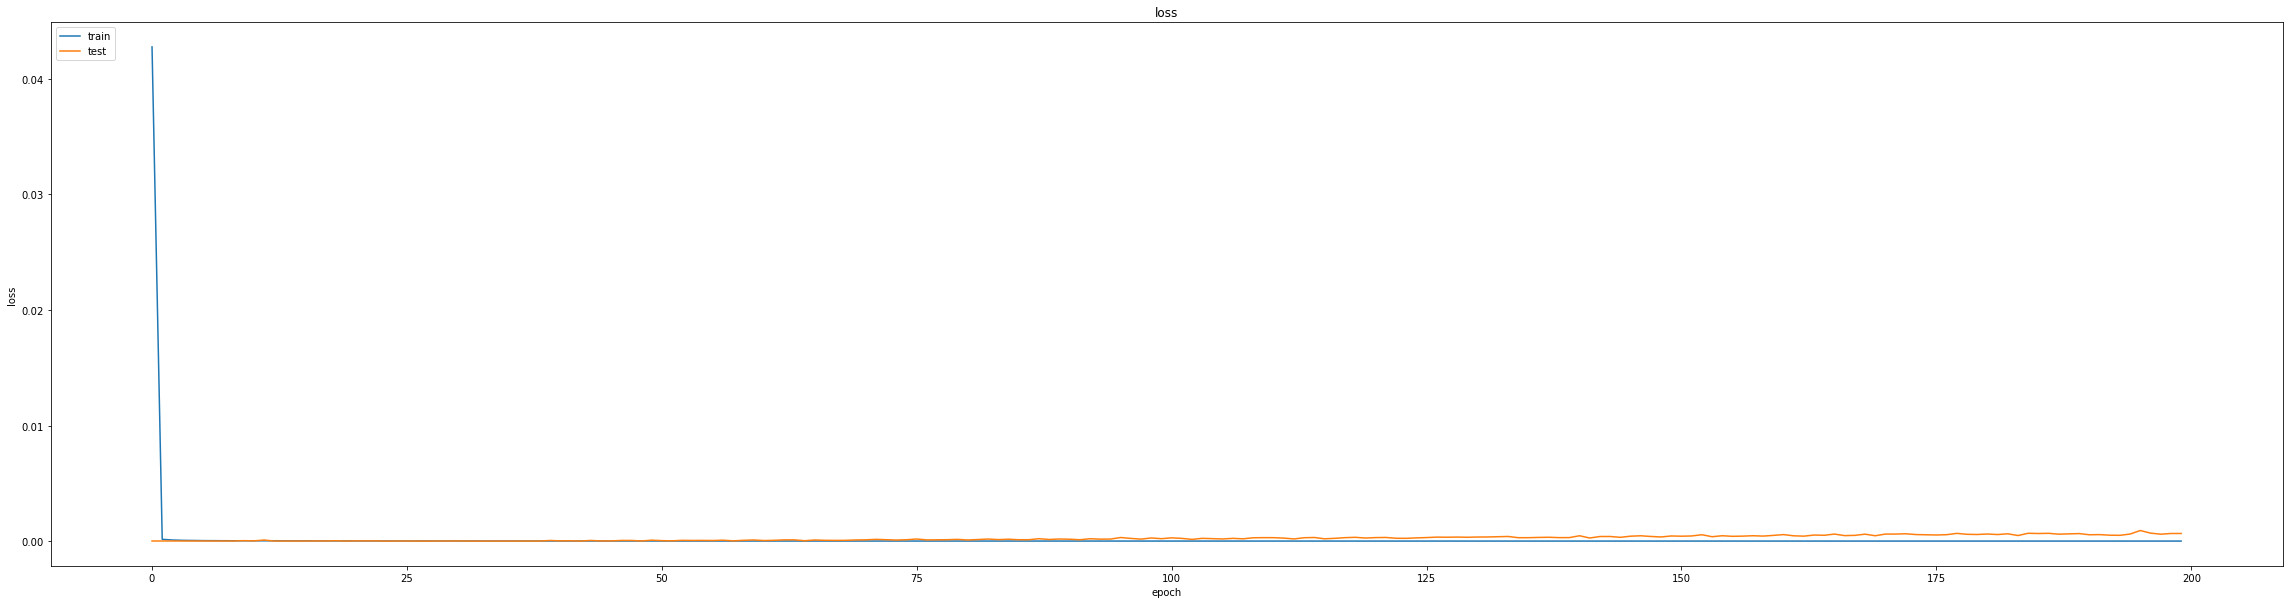

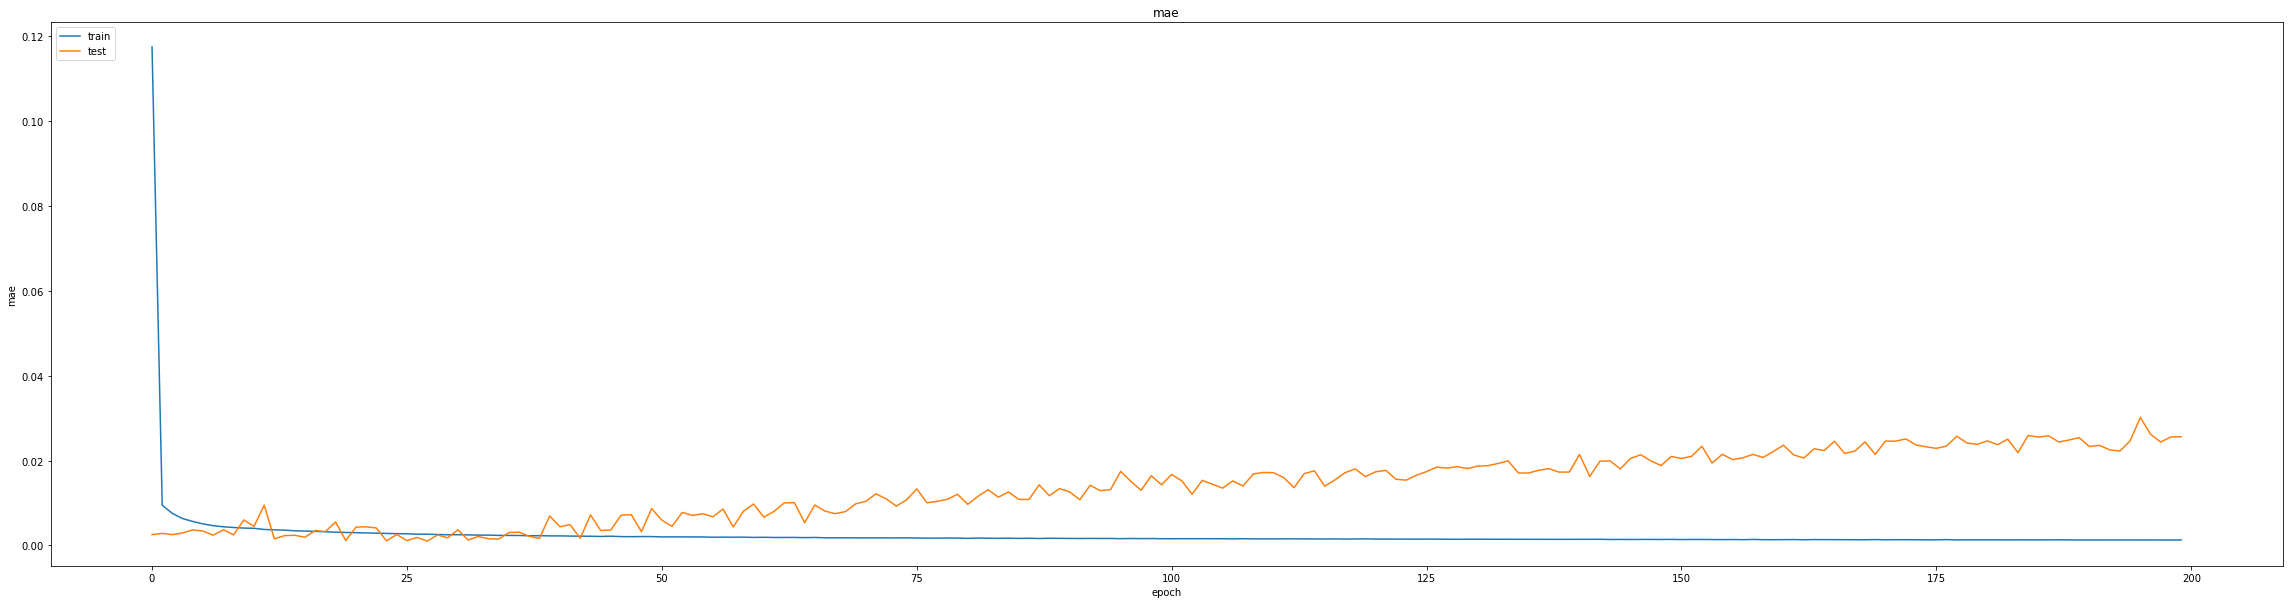

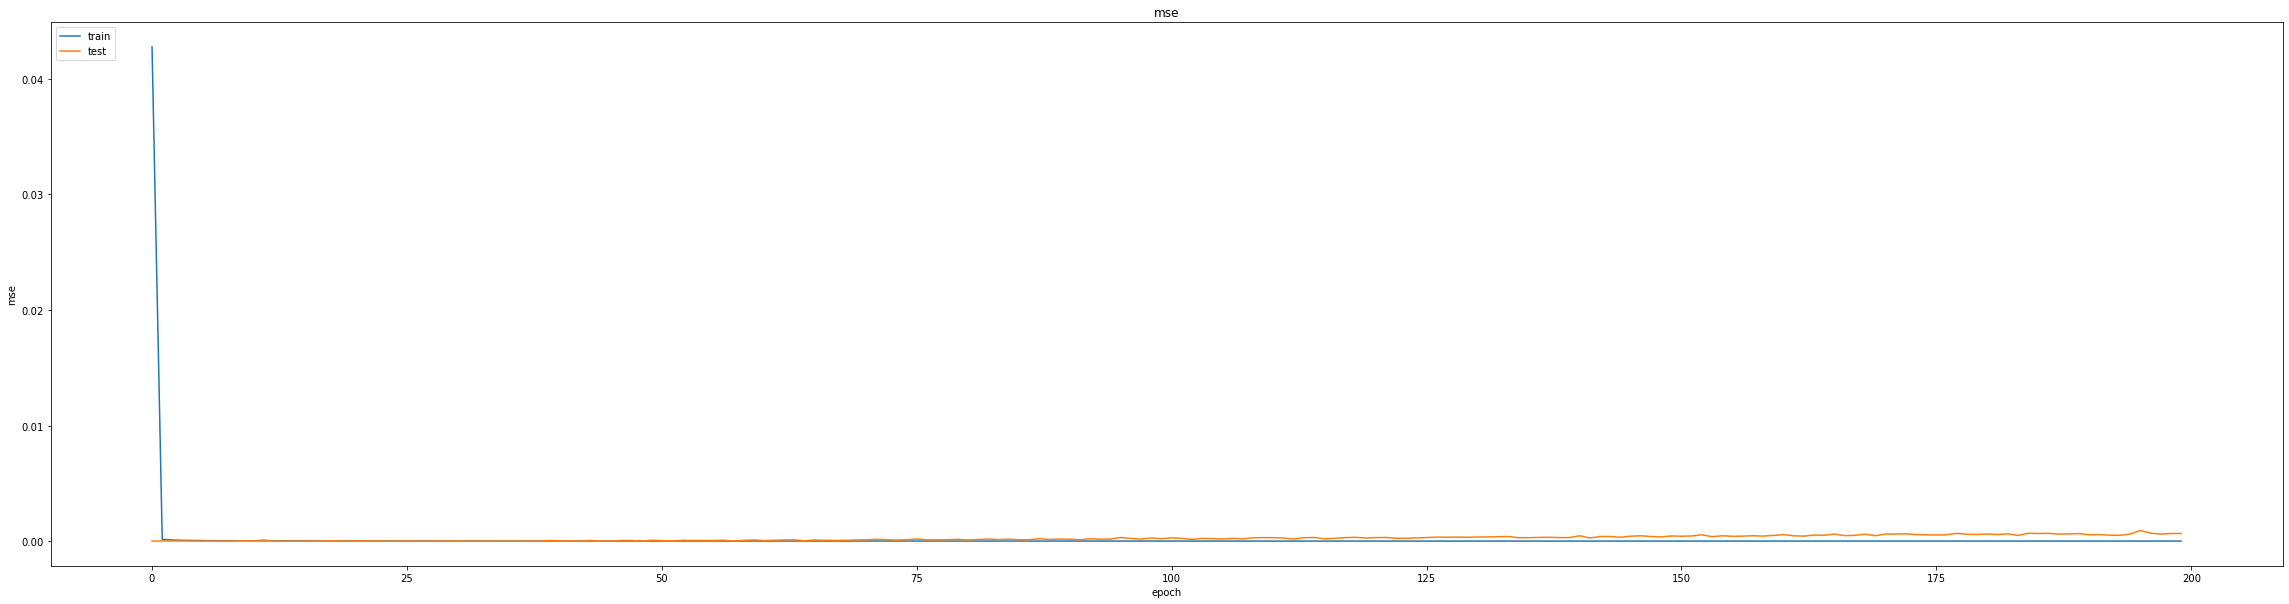

In [26]:
visualize_history()

In [77]:
# To improve the weights towards the global optimal, I retrained the model with LearningRateScheduler added

from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
def scheduler(epoch):
    if epoch%10==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.9)
        print("lr changed to {}".format(lr*.9))
    return K.get_value(model.optimizer.lr)
lr_decay = LearningRateScheduler(scheduler)
callbacks_list = [checkpoint, lr_decay] # , tensorboard]
history = model.fit(trainX, trainY, epochs=5, batch_size=1024, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/5
407/407 [==============================] - ETA: 0s - loss: 1.0457e-04 - mae: 0.0049 - mse: 1.0457e-04
Epoch 00001: val_mse did not improve from 0.00000
407/407 [==============================] - 53s 131ms/step - loss: 1.0457e-04 - mae: 0.0049 - mse: 1.0457e-04 - val_loss: 2.4522e-06 - val_mae: 0.0012 - val_mse: 2.4522e-06 - lr: 0.0010
Epoch 2/5
407/407 [==============================] - ETA: 0s - loss: 1.2690e-05 - mae: 0.0027 - mse: 1.2690e-05
Epoch 00002: val_mse did not improve from 0.00000
407/407 [==============================] - 53s 130ms/step - loss: 1.2690e-05 - mae: 0.0027 - mse: 1.2690e-05 - val_loss: 2.0394e-06 - val_mae: 0.0010 - val_mse: 2.0394e-06 - lr: 0.0010
Epoch 3/5
407/407 [==============================] - ETA: 0s - loss: 1.0968e-05 - mae: 0.0025 - mse: 1.0968e-05
Epoch 00003: val_mse did not improve from 0.00000
407/407 [==============================] - 55s 136ms/step - loss: 1.0968e-05 - mae: 0.0025 - mse: 1.0968e-05 - val_loss: 2.0293e-06 - val_mae: 0

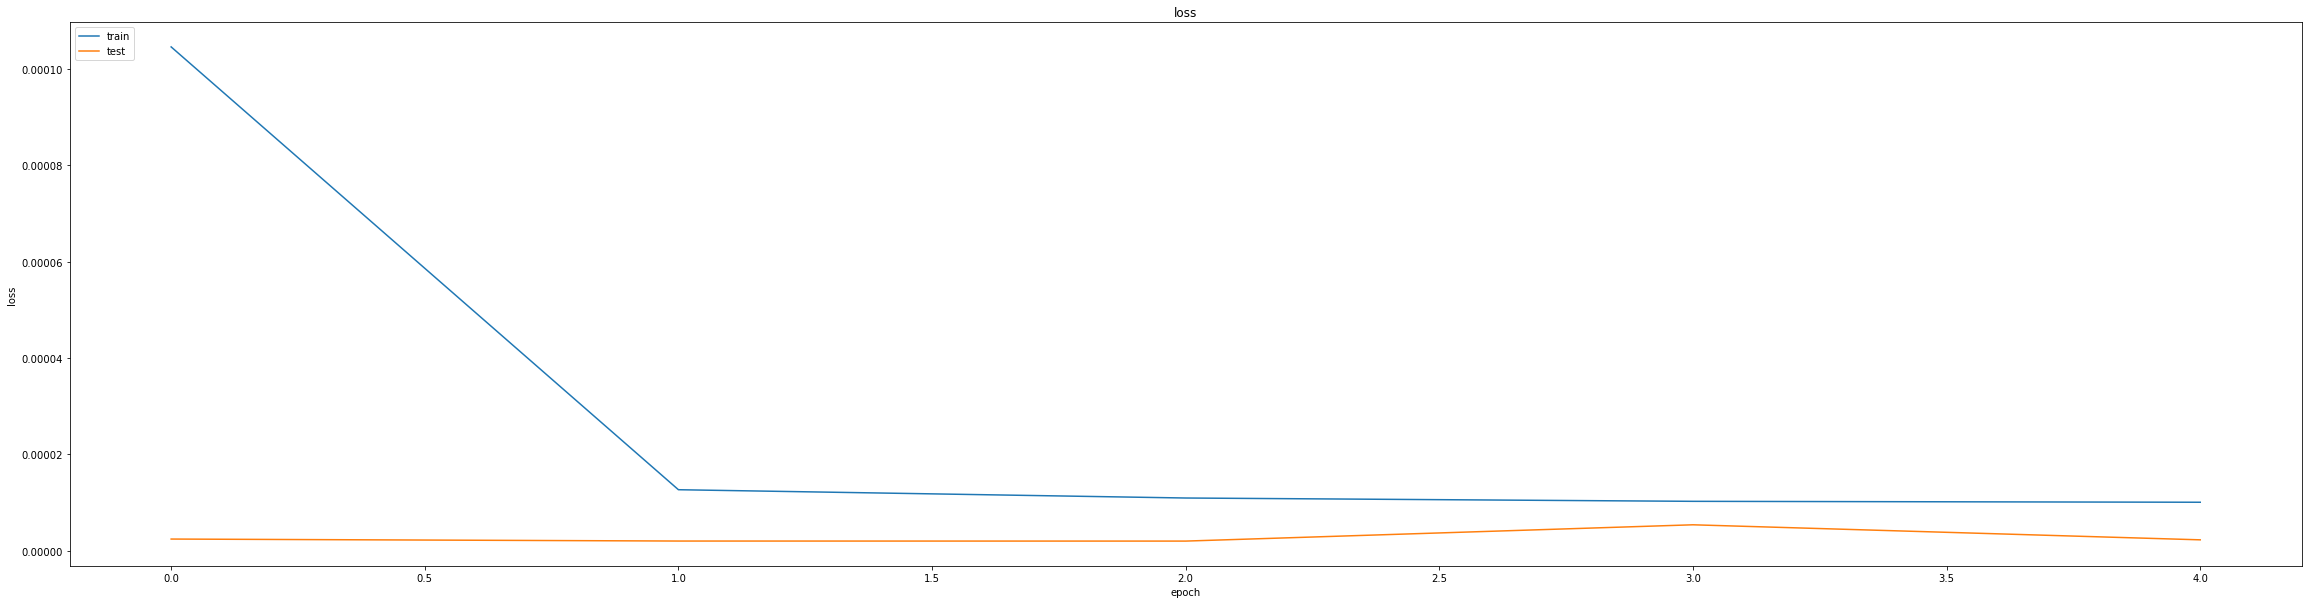

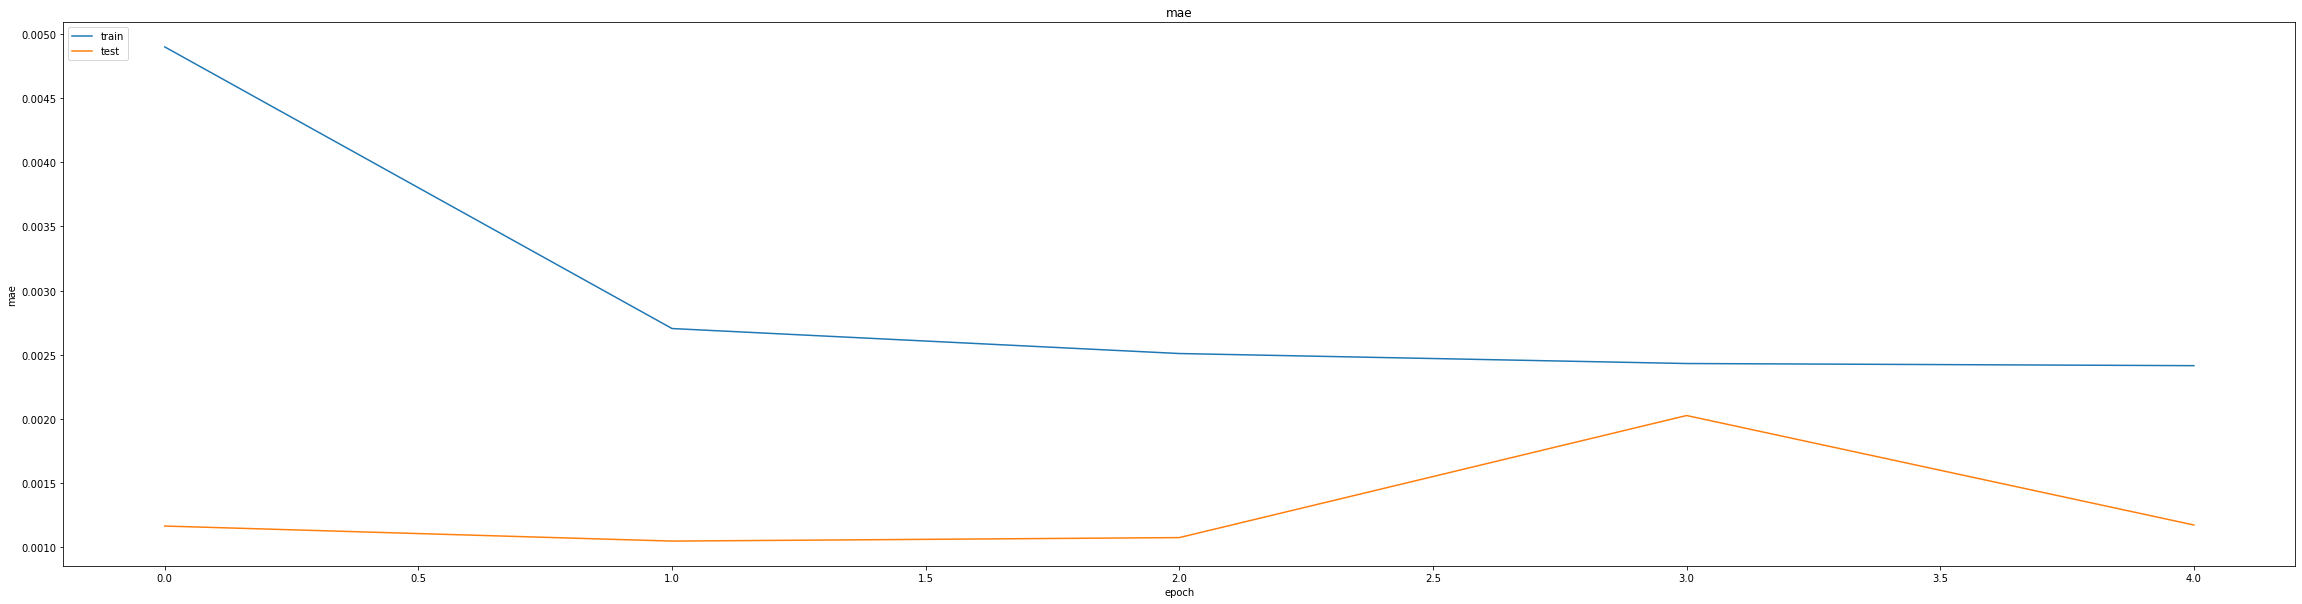

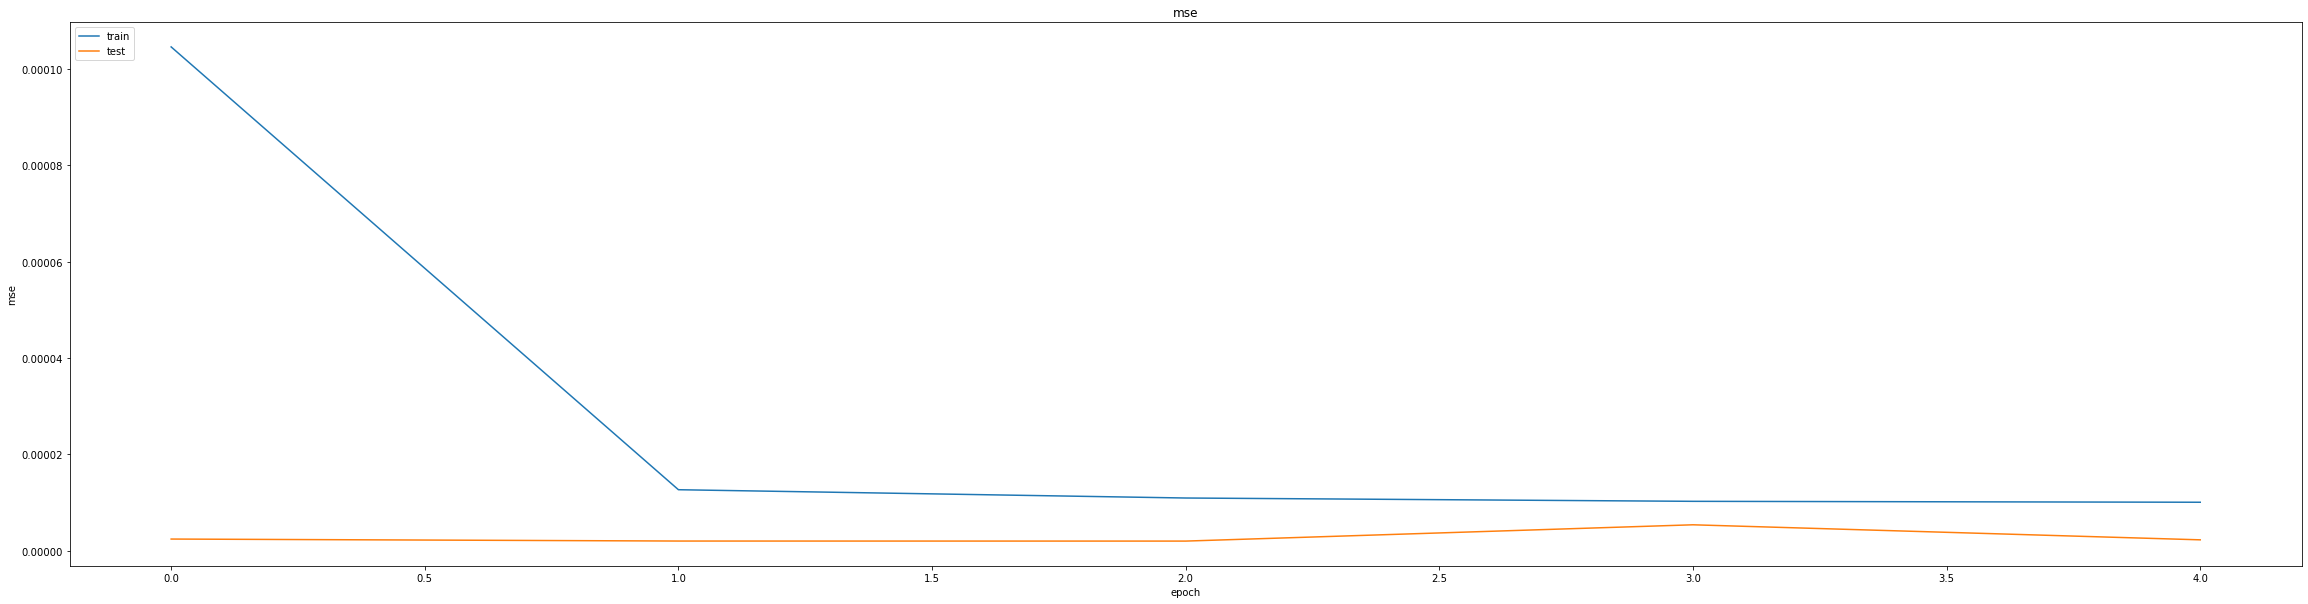

In [81]:
visualize_history()

# Testing
Once the training was complete, I’ve loaded the best weights discovered to my model and checked if the prediction worked as intended.

In [29]:
model.load_weights("weights.best.hdf5") # load best validation 

In [30]:
pred = model.predict(testX)

# Plot Scaled Predictions vs Scaled Actual Price

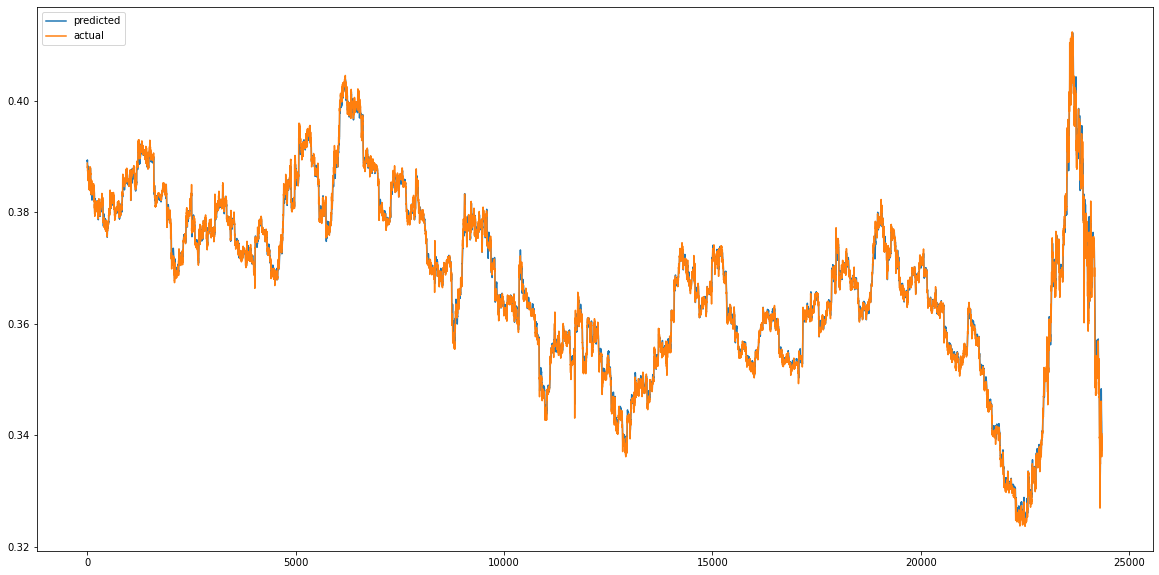

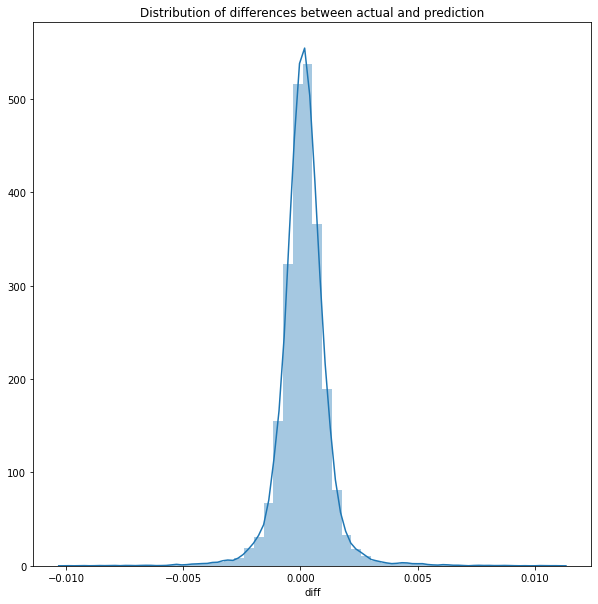

MSE :  1.0765772043085829e-06
MAE :  0.0006943525095743965


count    24345.000000
mean         0.000133
std          0.001029
min         -0.009909
25%         -0.000352
50%          0.000129
75%          0.000621
max          0.010920
Name: diff, dtype: float64

In [32]:
from sklearn.metrics import mean_absolute_error 

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['actual'] = testY
predictions = predictions.astype(float)

predictions.plot(figsize=(20,10))
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction')
plt.show()

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values))
predictions['diff'].describe()

# Compare the unscaled values and see if the prediction falls within the Low and High

In [44]:
pred = model.predict(testX)

In [34]:
pred = y_scaler.inverse_transform(pred)
close = y_scaler.inverse_transform(np.reshape(testY, (testY.shape[0], 1)))

predictions = pd.DataFrame()
predictions['predicted'] = pd.Series(np.reshape(pred, (pred.shape[0])))
predictions['close'] = pd.Series(np.reshape(close, (close.shape[0])))

In [35]:
p = merged_data[-pred.shape[0]:].copy()
predictions.index = p.index
predictions = predictions.astype(float)
predictions = predictions.merge(p[['low_'+PREDICTING_PAIR, 'high_'+PREDICTING_PAIR]], right_index=True, left_index=True)

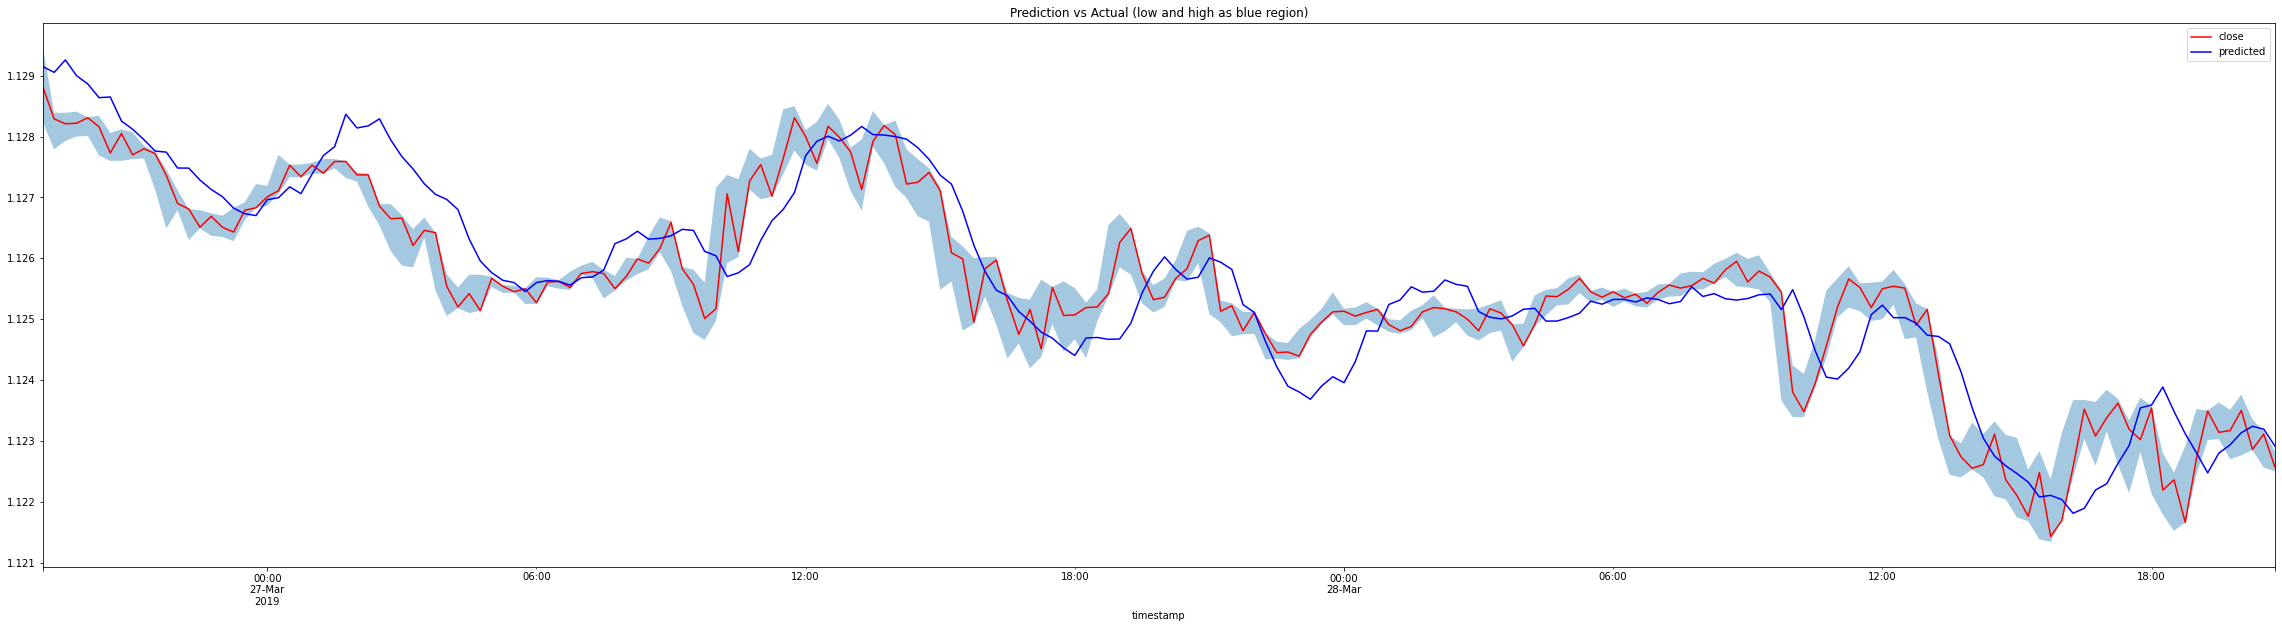

In [85]:
zoom = 200

ax = predictions[:zoom].plot(y='close', c='red', figsize=(40,10))
ax = predictions[:zoom].plot(y='predicted', c='blue', figsize=(40,10), ax=ax)
index = [str(item) for item in predictions[:zoom].index]
plt.fill_between(x=index, y1='low_'+PREDICTING_PAIR, y2='high_'+PREDICTING_PAIR, data=p[:zoom], alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

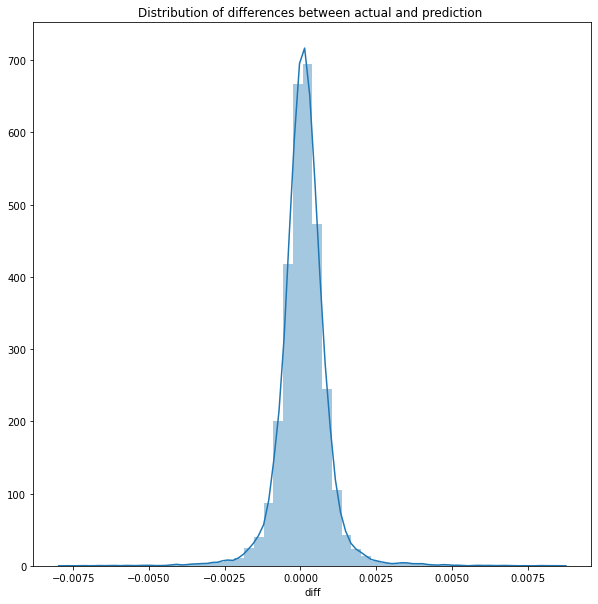

In [37]:
predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10,10))
sns.distplot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

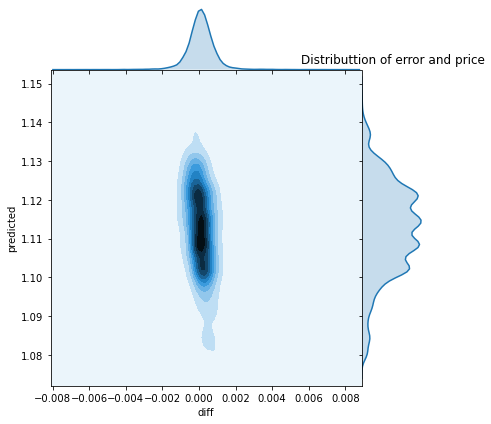

In [38]:
g = sns.jointplot("diff", "predicted", data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

In [40]:
print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()

MSE :  6.442860745715891e-07
MAE :  0.0005371515352786212


count    24345.000000
mean         0.000103
std          0.000796
min         -0.007666
25%         -0.000273
50%          0.000100
75%          0.000481
max          0.008448
Name: diff, dtype: float64